# Übung 4 – Gruppenvergleich mit nicht normalverteilten Daten (Titanic)

## Lernziele
- Schiefe Verteilungen erkennen und analysieren
- Den passenden Gruppenvergleich für nicht-normalverteilte Daten auswählen
- Kruskal-Wallis Test als nicht-parametrische Alternative zur ANOVA durchführen
- Rangbasierte Post-hoc Tests (Dunn Test) anwenden
- False Discovery Rate (FDR) Korrektur nach Benjamini-Hochberg durchführen
- Medianwerte und robuste Statistiken nutzen

---

## Fragestellung

Prüfen Sie, ob sich die Ticketpreise (**Fare**) zwischen den drei Passagierklassen unterscheiden:

- 1st class (Erste Klasse)
- 2nd class (Zweite Klasse)
- 3rd class (Dritte Klasse)

---

## Importiere notwendige Bibliotheken

Führe diese Zelle aus, bevor du mit den Aufgaben beginnst:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import kruskal
import scikit_posthocs as sp

from statsmodels.stats.multitest import fdrcorrection

In [2]:
# Einstellungen für bessere Plots und Pandas Optionen
plt.rcParams['figure.figsize'] = (10, 6)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.precision', 4)

---

# Teil 1 – Aufbereiteter Datensatz wird gegeben

### Datensatz laden

In [3]:
df = sns.load_dataset("titanic")

### Überblick über die Daten

In [4]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [5]:
# Deskriptive Statistiken nach Klasse
print("Deskriptive Statistiken nach Passagierklasse:\n")
summary = df.groupby('pclass')['fare'].describe()
print(summary)

Deskriptive Statistiken nach Passagierklasse:

        count     mean      std  min      25%      50%   75%       max
pclass                                                                
1       216.0  84.1547  78.3804  0.0  30.9239  60.2875  93.5  512.3292
2       184.0  20.6622  13.4174  0.0  13.0000  14.2500  26.0   73.5000
3       491.0  13.6756  11.7781  0.0   7.7500   8.0500  15.5   69.5500


In [6]:
# Anzahl Beobachtungen pro Klasse
print("\nAnzahl Passagiere pro Klasse:")
print(df['pclass'].value_counts().sort_index())


Anzahl Passagiere pro Klasse:
pclass
1    216
2    184
3    491
Name: count, dtype: int64


---

# Teil 2 – Explorative Analyse

## Aufgabe 1 – Verteilungen visualisieren und analysieren (Wiederholung)

**Ziel:** Die Verteilung der Ticketpreise pro Klasse untersuchen und Schiefe sowie Ausreißer identifizieren.

**Aufgaben:**

a. Erstelle einen Boxplot der Ticketpreise nach Passagierklasse

b. Erstelle ein Histogramm für jede Klasse

c. Berechne Schiefe (Skewness) für jede Klasse

d. Beantworte die Interpretationsfragen

### a. Boxplot nach Passagierklasse

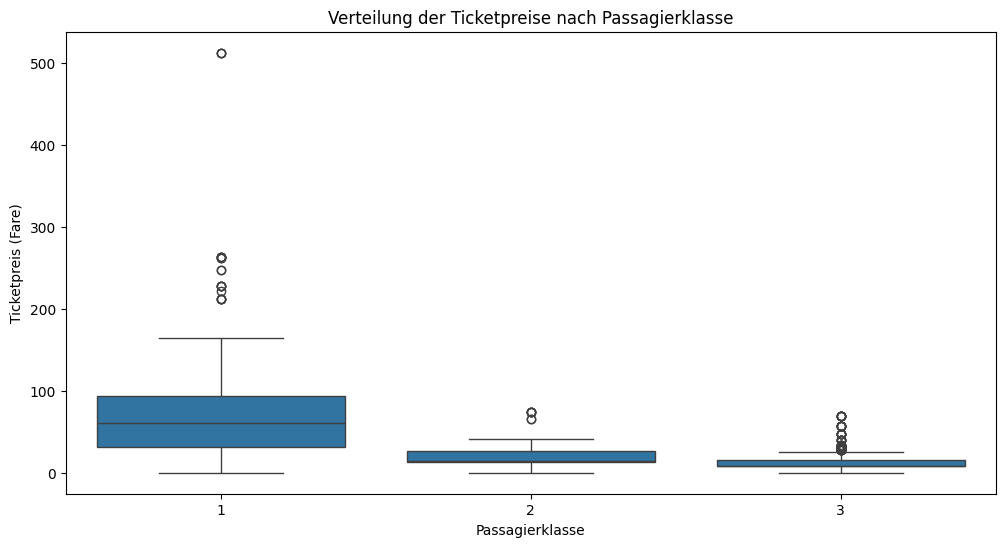

In [9]:
plt.figure(figsize=(12, 6))

# Erstelle Boxplot

sns.boxplot(x="pclass", y="fare", data=df)

plt.xlabel("Passagierklasse")
plt.ylabel("Ticketpreis (Fare)")
plt.title("Verteilung der Ticketpreise nach Passagierklasse")
plt.show()

### b. Histogramm für jede Klasse

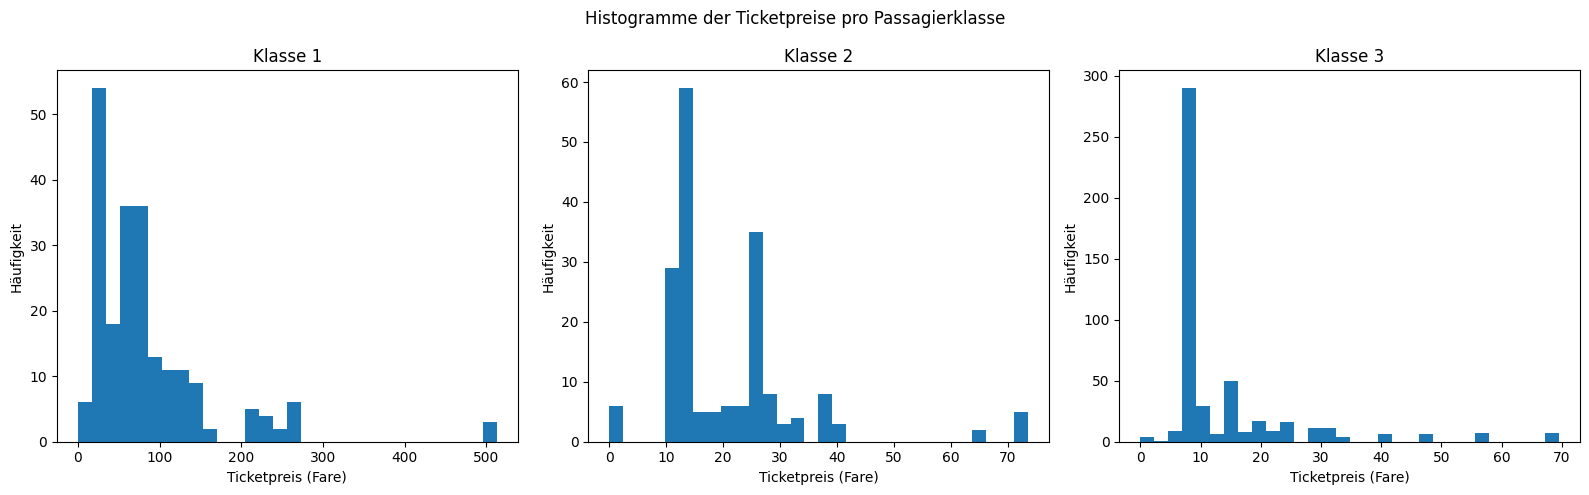

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Erstelle Histogramm für jede Klasse
classes = [1, 2, 3]

for ax, cls in zip(axes, classes):
    fares_cls = df.loc[df["pclass"] == cls, "fare"].dropna()
    ax.hist(fares_cls, bins=30)
    ax.set_title(f"Klasse {cls}")
    ax.set_xlabel("Ticketpreis (Fare)")
    ax.set_ylabel("Häufigkeit")

fig.suptitle("Histogramme der Ticketpreise pro Passagierklasse")
plt.tight_layout()
plt.show()

### c. Schiefe berechnen

In [11]:
# Berechne Schiefe (stats.skew)
fares_1st = df.loc[df["pclass"] == 1, "fare"].dropna()
fares_2nd = df.loc[df["pclass"] == 2, "fare"].dropna()
fares_3rd = df.loc[df["pclass"] == 3, "fare"].dropna()

skew_1st = stats.skew(fares_1st, bias=False)
skew_2nd = stats.skew(fares_2nd, bias=False)
skew_3rd = stats.skew(fares_3rd, bias=False)

print("Schiefe (Skewness) der Ticketpreise pro Klasse:")
print(f"  1. Klasse: {skew_1st:.3f}")
print(f"  2. Klasse: {skew_2nd:.3f}")
print(f"  3. Klasse: {skew_3rd:.3f}")

Schiefe (Skewness) der Ticketpreise pro Klasse:
  1. Klasse: 2.835
  2. Klasse: 2.038
  3. Klasse: 2.736


### d. Interpretation

**Fragen zur Interpretation:**

1. **Was beobachten Sie bezüglich der Verteilungsform der Ticketpreise?**
   Die Ticketpreise sind in allen drei Klassen stark rechtsschief verteilt: Es gibt viele relativ niedrige Ticketpreise und wenige sehr hohe Werte. Die 1. Klasse hat deutlich höhere Ticketpreise. Der Boxplot liegt insgesamt auf einem viel höheren Niveau (Median deutlich über 50), während die 2. und 3. Klasse hauptsächlich im Bereich unter 40 liegen.Mit steigender Klasse verschieben sich die Verteilungen zu höheren Werten (1. Klasse > 2. Klasse > 3. Klasse).

2. **Sind die Daten normalverteilt? Begründen Sie mit Bezug auf Skweness-Werte.**
   Nein, die Daten sind nicht normalverteilt. Die Histogramme zeigen eine deutliche Rechts-Schiefe, und die Skewness-Werte sind deutlich größer als 0 (stark positive Schiefe). Eine Normalverteilung wäre symmetrisch mit Skewness ≈ 0. Werte über ±0.5 gelten meist schon als deutliche Schiefe und die berechneten Werte sind alle deutlich über 2.

3. **Ist ANOVA sinnvoll? Wenn nicht, warum?**
   Eine klassische ANOVA setzt (annähernd) normalverteilte Residuen und keine starke Schiefe/Ausreißer voraus. Da die Verteilungen stark rechtsschief sind und Ausreißer vorhanden sind, ist die ANOVA hier problematisch. Deshalb ist es passend, auf einen nichtparametrischen Test wie den Kruskal-Wallis-Test auszuweichen.

4. **Welche Klasse hat die höchste Variabilität in den Ticketpreisen?**
   Die 1. Klasse zeigt die höchste Variabilität: der Boxplot hat eine Spannweite von nahe 0 bis über 500. 

5. **Gibt es sichtbare Ausreißer? In welchen Klassen?**
   Ja, es gibt sichtbare Ausreißer, vor allem in der 1. Klasse. Es gibt viele Ausreißer zwischen 200-300, aber auch einen bei über 500. Auch in der 2. und 3. Klasse können einzelne Ausreißer auftreten, aber deutlich weniger ausgeprägt als in der 1. Klasse. Es gibt keine, die höher als 100 sind.

---

# Teil 3 – Globaler Test

## Aufgabe 2 – Kruskal-Wallis Test durchführen

**Ziel:** Prüfen, ob sich die Ticketpreise zwischen den drei Passagierklassen unterscheiden.

**Hintergrund:**
- Der Kruskal-Wallis Test ist ein nicht-parametrischer Test für den Vergleich von mehr als zwei Gruppen
- Er basiert auf Rängen statt auf den eigentlichen Werten
- Robust gegenüber Nicht-Normalität und Ausreißern

**Hypothesen:**
- H₀: Alle drei Klassen haben die gleiche Verteilung der Ticketpreise
- H₁: Mindestens eine Klasse unterscheidet sich von den anderen

**Aufgaben:**

a. Führe den Kruskal-Wallis Test durch

b. Interpretiere das Ergebnis (α = 0.05)

### a. Kruskal-Wallis Test durchführen

In [12]:
# Separiere die Daten nach Passagierklasse und entferne fehlende Werte
group_1st = df.loc[df["pclass"] == 1, "fare"].dropna()
group_2nd = df.loc[df["pclass"] == 2, "fare"].dropna()
group_3rd = df.loc[df["pclass"] == 3, "fare"].dropna()

In [13]:
print(f"Gruppengrößen:")
print(f"  1. Klasse: n = {len(group_1st)}")
print(f"  2. Klasse: n = {len(group_2nd)}")
print(f"  3. Klasse: n = {len(group_3rd)}")

Gruppengrößen:
  1. Klasse: n = 216
  2. Klasse: n = 184
  3. Klasse: n = 491


In [14]:
# Führe Kruskal-Wallis Test durch
h_statistic, p_value = kruskal(group_1st, group_2nd, group_3rd)

In [15]:
print("\n" + "="*60)
print("KRUSKAL-WALLIS TEST ERGEBNISSE")
print("="*60)
print(f"H-Statistik: {h_statistic}")
print(f"p-Wert: {p_value}")
print("="*60)


KRUSKAL-WALLIS TEST ERGEBNISSE
H-Statistik: 438.0437034212556
p-Wert: 7.586096900646798e-96


In [16]:
# Entscheidung
alpha = 0.05
if p_value < alpha:
    print("H0 wird...")
    print("→ H₀ wird VERWORFEN")
    print("→ Es gibt signifikante Unterschiede zwischen den Klassen.")
    print("→ Post-hoc Tests sind erforderlich!")
else:
    print("H0 wird...")
    print("→ H₀ wird NICHT verworfen")
    print("→ Es gibt keine ausreichenden Hinweise auf Unterschiede zwischen den Klassen.")

H0 wird...
→ H₀ wird VERWORFEN
→ Es gibt signifikante Unterschiede zwischen den Klassen.
→ Post-hoc Tests sind erforderlich!


### b. Interpretation

**Ergebnis:**

Der Kruskal-Wallis Test zeigt einen hoch signifikanten Unterschied zwischen den Ticketpreisen der drei Passagierklassen.



**Wird die Nullhypothese verworfen?**
- Antwort: Ja. Bei α = 0,05 wird H₀ eindeutig verworfen, weil der p-Wert (≈ 7,6 · 10⁻⁹⁶) extrem klein ist. Es gibt also sehr starke Evidenz dafür, dass sich die Verteilungen der Ticketpreise zwischen den Klassen unterscheiden.

**Sagt der Test welche Klassen sich unterscheiden? Wenn nicht was ist der nächste Schritt**
- Antwort: Nein, der Kruskal-Wallis-Test sagt nur, dass mindestens zwei Klassen sich unterscheiden, aber nicht welche.(z.B. Dunn-Test mit Korrektur für multiples Testen), um herauszufinden, welche Klassenpaare (1 vs. 2, 1 vs. 3, 2 vs. 3) sich signifikant unterscheiden.

**Was bedeutet der Wert für H-Statistik?**
- Antwort: Die H-Statistik misst, wie stark sich die Rangverteilungen der Gruppen unterscheiden. Ein so großer Wert wie H = 438,04 bedeutet, dass die Rangmittelwerte der Ticketpreise der drei Klassen sehr weit auseinanderliegen, also ein starker Hinweis auf unterschiedliche Verteilungen.

**Was bedeutet der p-Wert**
- Antwort: Der p-Wert von 7,586 · 10⁻⁹⁶ ist die Wahrscheinlichkeit, unter der Annahme der Nullhypothese (alle Klassen haben gleiche Verteilung der Ticketpreise) eine H-Statistik von 438,04 oder extremer zu beobachten.
Da dieser Wert praktisch 0 ist, ist es extrem unwahrscheinlich, dass die beobachteten Unterschiede zufällig entstanden sind, daher die klare Verwerfung von H₀.

---

# Teil 4 – Post-hoc Tests

## Aufgabe 3 – Dunn Test durchführen

**Ziel:** Paarweise Vergleiche zwischen den Klassen durchführen.

**Hintergrund:**
- Der Dunn Test ist ein rangbasierter Post-hoc Test für Kruskal-Wallis
- Er vergleicht alle Gruppenpaare miteinander
- Bei 3 Gruppen ergeben sich 3 Vergleiche (3 p-Werte)

**Aufgaben:**

a. Führe den Dunn Test durch (ohne p-Wert-Korrektur)

b. Zeige die rohen p-Werte für alle Paarvergleiche

c. Diskutiere das Problem des multiplen Testens

### a. Dunn Test durchführen

In [ ]:
# Führe Dunn Test durch
dunn_result =

In [ ]:
print("\n" + "="*60)
print("DUNN TEST ERGEBNISSE (rohe p-Werte)")
print("="*60)
print(dunn_result)
print("="*60)

### b. Paarvergleiche extrahieren und anzeigen

In [ ]:
# Extrahiere die paarweisen p-Werte
p_1vs2 =
p_1vs3 =
p_2vs3 =

In [ ]:
# Erstelle Übersichtstabelle


### c. Problem des multiplen Testens

**Was ist das Problem wenn man mehrere Hypothesentest gleichzeitig durchführt?**
- Antwort:


**Wie löst man das Problem? Was sind mögliche Methoden?**
- Antwort:

---

# Teil 5 – Fehlerkontrolle

## Aufgabe 4 – False Discovery Rate (FDR) Korrektur

**Ziel:** Die p-Werte mit dem Benjamini-Hochberg Verfahren korrigieren.

**Hintergrund:**
- **FDR (False Discovery Rate)**: Kontrolliert den erwarteten Anteil an Falschentdeckungen unter den als signifikant deklarierten Tests
- **Benjamini-Hochberg Verfahren**: Weniger konservativ als Bonferroni, mehr statistische Power

**Aufgaben:**

a. Wende die Benjamini-Hochberg Korrektur auf die drei p-Werte an

b. Vergleiche rohe und korrigierte p-Werte

c. Entscheide, welche Vergleiche signifikant sind

### a. Benjamini-Hochberg Korrektur anwenden

In [ ]:
# Sammle alle rohen p-Werte

# Wende Benjamini-Hochberg Korrektur an


In [ ]:
print("\n" + "="*70)
print("FDR KORREKTUR (Benjamini-Hochberg)")
print("="*70)
print(f"Signifikanzniveau (α): 0.05")
print(f"Anzahl Tests: {len(raw_pvalues)}")
print("="*70)

### b. Vergleichstabelle erstellen (Roher p-wert, Korrigierter p-wert, Signifikanz, Median Differenz)

In [ ]:
# Erweitere die Vergleichstabelle


In [ ]:
print("\nVergleichstabelle mit FDR-Korrektur:")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)

### c. Zusammenfassung der Ergebnisse

In [ ]:
# Zähle signifikante Vergleiche
n_significant = sum(rejected)

print(f"\n{'='*60}")
print("ZUSAMMENFASSUNG")
print("="*60)
print(f"Anzahl durchgeführter Vergleiche: {len(raw_pvalues)}")
print(f"Anzahl signifikanter Vergleiche (nach FDR): {n_significant}")
print("="*60)

if n_significant > 0:
    print("\nSignifikante Unterschiede gefunden bei:")
    for i, (comp, is_sig) in enumerate(zip(comparison_df['Vergleich'], rejected)):
        if is_sig:
            print(f"  ✓ {comp} (p_korr = {corrected_pvalues[i]:})")
else:
    print("\nKeine signifikanten Unterschiede nach FDR-Korrektur.")

**Interpretation:**

Die FDR-Korrektur nach Benjamini-Hochberg zeigt, welche Paarvergleiche auch nach Korrektur für multiples Testen signifikant bleiben.

**Erwartetes Muster:**
- 1. Klasse zahlt deutlich mehr als 2. und 3. Klasse → signifikant
- 2. Klasse zahlt mehr als 3. Klasse → signifikant
- Alle drei Klassen unterscheiden sich signifikant voneinander

**Hinweis:** Die korrigierten p-Werte können größer sein als die rohen p-Werte, sind aber immer noch interpretierbar als adjustierte Signifikanzniveaus.

---

# Teil 6 – Interpretation

## Aufgabe 5 – Ergebnisse interpretieren

**Ziel:** Das Muster der Unterschiede beschreiben

**Aufgaben:**

a. Beschreibe das Muster der Unterschiede

b. Diskutiere die praktische vs. statistische Signifikanz

### a. Beschreibung des Musters (Lücken ausfüllen)

**Zusammenfassung der Ergebnisse:**

Die statistische Analyse zeigt _____________ .

1. **Globaler Test (Kruskal-Wallis)**:
   - __________ Unterschied zwischen den drei Passagierklassen (p < 0.001)
   - Die Verteilung der Ticketpreise _______________ zwischen den Klassen

2. **Post-hoc Tests (Dunn mit FDR-Korrektur)**:
   - **1. Klasse vs. 2. Klasse**: ______________
   - **1. Klasse vs. 3. Klasse**: ______________
   - **2. Klasse vs. 3. Klasse**: _____________
   
3. **Größe der Effekte (Mediane)**:
   - 1.Klasse:
   - 2.Klasse:
   - 3.Klasse:
   - Die 1. Klasse ist etwa ____ teurer als die 3. Klasse


### b. Praktische vs. statistische Signifikanz (Lücken ausfüllen)

**Diskussion:**

**Statistische Signifikanz:**
- Alle Paarvergleiche sind ________________ (p < 0.05 nach FDR-Korrektur)
- Die Wahrscheinlichkeit, dass diese Unterschiede durch Zufall entstanden sind, ist ________

**Praktische Signifikanz:**
- Die **Effektgrößen sind _________**: Die 1. Klasse kostet 3-4x mehr als die 3. Klasse
- Die Unterschiede spiegeln die historische Realität der Titanic wider:
  - Erste Klasse: Luxuriöse Suiten, exklusiver Service
  - Dritte Klasse: Einfache Unterkünfte, Basis-Service

**Methodische Erkenntnisse:**
- Der nicht-parametrische Ansatz (Kruskal-Wallis + Dunn) war die ________ Wahl. ANOVA wäre in diesem Kontext ____________ .
- Die FDR-Korrektur verhindert _____________ Ergebnisse bei multiplen Tests
- Trotz starker Rechtsschiefe und Ausreißern konnten wir robuste Schlüsse ziehen



---